In [1]:
import json
import os
import math
from tqdm import tqdm

def load_game(filename: str) -> dict:
    """Load game data from a JSON file."""
    with open(filename, 'r') as file:
        data = json.load(file)
    return data


games = []
game_path = os.path.join(".", "games", "classic")

for file in tqdm(os.listdir(game_path)):
    if file.endswith(".json"):
        game_data = load_game(os.path.join(game_path, file))
        games.append(game_data)

print(f"Loaded {len(games)} games.")

players = []
players_name_lvl = {}
for game in tqdm(games):
    for participant in game.get("info").get("participants", []):
        players_name_lvl[participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")] = participant.get("summonerLevel", 0)

for name, level in players_name_lvl.items():
    players.append((name, level))

print(f"Unique players: {len(players)}")



  0%|          | 0/16071 [00:00<?, ?it/s]

100%|██████████| 16071/16071 [01:22<00:00, 194.28it/s]


Loaded 16071 games.


100%|██████████| 16071/16071 [00:00<00:00, 22350.05it/s]


Unique players: 124693


In [2]:
def plot_level_distribution(games: list):
    import matplotlib.pyplot as plt

    # Levels einsammeln
    levels = []
    for game in games:
        for participant in game.get("info", {}).get("participants", []):
            levels.append(participant.get("summonerLevel", 0))

    # Figur
    plt.figure(figsize=(16, 10))

    # Histogramm mit schöneren Styles
    plt.hist(
        levels,
        bins=range(1, max(levels) + 2),
        edgecolor="green",        # dünne Linien für klarere Balken
        alpha=0.75,               # etwas Transparenz
        linewidth=1.0
    )
    plt.locator_params(axis="x", nbins=40)
    # Titel und Achsen
    plt.title("Distribution of Account Levels", fontsize=20, pad=15)
    plt.xlabel("Level", fontsize=16)
    plt.ylabel("Number of Accounts", fontsize=16)

    # Schönes Grid
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Ticks lesbarer machen
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Layout optimieren
    plt.tight_layout()

    plt.show()

def get_team_levels(game: dict) -> tuple:
    team1_levels = []
    team2_levels = []
    for participant in game.get("info").get("participants", []):
        if participant.get("teamId") == 100:
            team1_levels.append(participant.get("summonerLevel", 0))
        else:
            team2_levels.append(participant.get("summonerLevel", 0))
    return sum(team1_levels) / len(team1_levels), sum(team2_levels) / len(team2_levels)

def get_percentage_of_surrendered_games(games: dict) -> float:
    surrendered_games = 0
    for game in games:
        s = game.get("info").get("participants", [])[0]["gameEndedInSurrender"]
        es = game.get("info").get("participants", [])[0]["gameEndedInEarlySurrender"]
        if s == True or es == True:
            surrendered_games += 1
    return surrendered_games/len(games)

def get_team_champion_levels(game: dict) -> tuple:
    team1_levels = []
    team2_levels = []
    for participant in game.get("info").get("participants", []):
        if participant.get("teamId") == 100:
            team1_levels.append(participant.get("champExperience", 0))
        else:
            team2_levels.append(participant.get("champExperience", 0))
    return sum(team1_levels) / len(team1_levels), sum(team2_levels) / len(team2_levels)

def get_team_min_max_level(game: dict) -> tuple:
    team1_max_level = 0
    team1_min_level = math.inf
    team2_max_level = 0
    team2_min_level = math.inf

    for p in game.get("info").get("participants", []):
        if p.get("teamId") == 100:
            if p.get("summonerLevel", 0) > team1_max_level:
                team1_max_level = p.get("summonerLevel", 0)
            if p.get("summonerLevel", 0) < team1_min_level:
                team1_min_level = p.get("summonerLevel", 0)
        if p.get("teamId") == 200:
            if p.get("summonerLevel", 0) > team2_max_level:
                team2_max_level = p.get("summonerLevel", 0)
            if p.get("summonerLevel", 0) < team2_min_level:
                team2_min_level = p.get("summonerLevel", 0)
    return ((team1_min_level, team1_max_level), (team2_min_level, team2_max_level))

def higher_absolute_level_winrate(games:list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_max_level = 0
    won_with_lower_max_level = 0

    for game in games:
        l = get_team_min_max_level(game)
        team1_min_level, team1_max_level = l[0]
        team2_min_level, team2_max_level = l[1]
        team1_win = False
        team2_win = False

        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True

        if team1_max_level > team2_max_level and abs(team1_max_level - team2_max_level) > difference:
            all_games += 1
            if team1_win:
                won_with_higher_max_level += 1
            if team2_win:
                won_with_lower_max_level += 1

        if team2_max_level > team1_max_level and abs(team1_max_level - team2_max_level) > difference:
            all_games += 1
            if team1_win:
                won_with_lower_max_level += 1
            if team2_win:
                won_with_higher_max_level += 1
    return won_with_higher_max_level/all_games

def higher_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    #print(f"{won_with_higher_level} Wins with higher level and {won_with_lower_level} Wins with lower level of {all_games} games")
    if all_games > 0:
        return won_with_higher_level/all_games
    else:
        return 0
    
def higher_champion_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_champion_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    print(f"{won_with_higher_level} Wins with higher champion level and {won_with_lower_level} Wins with lower champion level of {all_games} games")
    if all_games > 0:
        return won_with_higher_level/all_games
    else:
        return 0
    
def lower_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    #print(f"{won_with_higher_level} Wins with higher level and {won_with_lower_level} Wins with lower level of {all_games} games")
    if all_games > 0:
        return won_with_lower_level/all_games
    else:
        return 0

def get_highest_level_player(games: list) -> tuple:
    highest_level = -1
    player_name = ""
    for game in games:
        for participant in game.get("info").get("participants", []):
            level = participant.get("summonerLevel", 0)
            if level > highest_level:
                highest_level = level
                player_name = participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")
    return player_name, highest_level

def get_all_participants(games: list) -> list:
    puuids = {}
    for game in tqdm(games):
        for participant in game.get("info").get("participants", []):
            puuids[participant.get("puuid")] = participant
    print(f"{len(puuids)} total number of players.")
    return puuids



In [3]:
len(get_all_participants(games))

100%|██████████| 16071/16071 [00:00<00:00, 28307.77it/s]

124574 total number of players.


124574

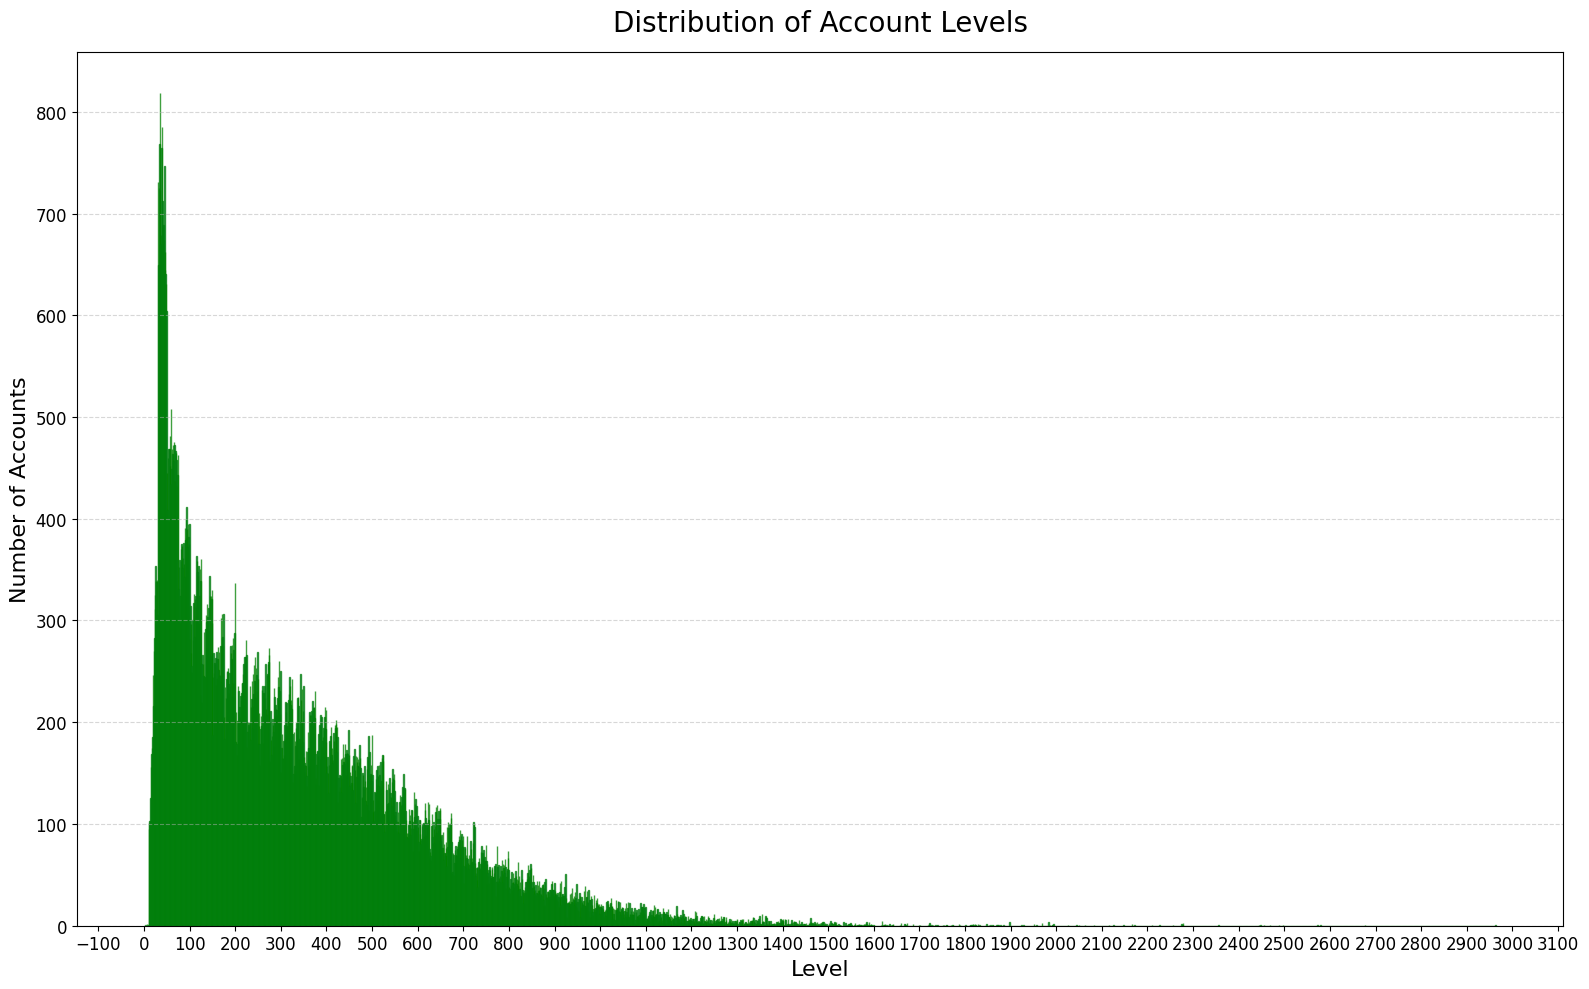

"Qnoxs #17165" Level: 2963


In [4]:
plot_level_distribution(games)
hname, hlevel = get_highest_level_player(games)
print(f"\"{hname}\" Level: {hlevel}")

100%|██████████| 61/61 [00:18<00:00,  3.34it/s]


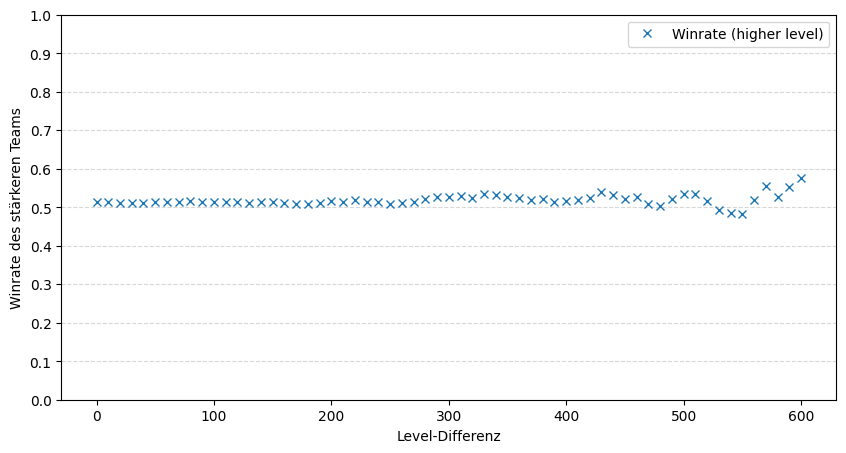

In [5]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 61)]
winrates = [higher_level_winrate(games, d) for d in tqdm(diffs)]

plt.figure(figsize=(10, 5))
plt.plot(diffs, winrates, marker="x", linestyle="", label="Winrate (higher level)")

plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.yticks([i/10 for i in range(0, 11)])

plt.xlabel("Level-Differenz")
plt.ylabel("Winrate des stärkeren Teams")
plt.legend()
plt.show()


  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:34<00:00,  2.90it/s]


[0.5085020242914979, 0.5087056714889259, 0.5098723180202711, 0.5100108225108225, 0.51089605235675, 0.5112593230063109, 0.5122329810037697, 0.5125666412795126, 0.5116498740554156, 0.5118475694161713, 0.5112775626998822, 0.5114517112252895, 0.5104617604617605, 0.5105194563396016, 0.5117806102742372, 0.5124049619847939, 0.5128497409326425, 0.5150472914875323, 0.5160931061365408, 0.5169745958429561, 0.5173035328046143, 0.518393814690111, 0.5196461098100442, 0.5200054252000542, 0.5180078784468205, 0.5171252927400468, 0.5193218267908966, 0.5181355392936685, 0.5160165975103734, 0.5170091521326196, 0.5173779938771835, 0.5178066704352742, 0.5182050777406022, 0.5188370188370188, 0.5183212611844908, 0.5226254480286738, 0.5215154349859682, 0.522911051212938, 0.524493459861503, 0.5224040783471962, 0.5213986013986014, 0.5222222222222223, 0.5227759095077957, 0.5225311601150527, 0.521985343104597, 0.5210970464135021, 0.522300036859565, 0.5211375864719446, 0.5195801372628179, 0.5188639253921153, 0.5147

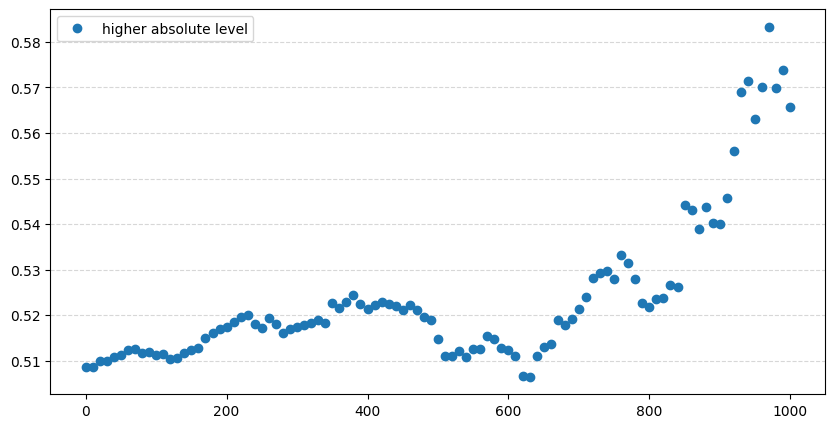

In [6]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 101)]
winrates_higher = [higher_absolute_level_winrate(games, d) for d in tqdm(diffs)]

print(winrates_higher)
plt.figure(figsize=(10, 5))

plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/100 for i in range(0, 101)])
plt.plot(diffs, winrates_higher, marker="o", linestyle="", label="higher absolute level")
plt.legend()
plt.show()

(21828.2, 18631.0)
[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000]
15435 Wins with higher champion level and 621 Wins with lower champion level of 16056 games
15122 Wins with higher champion level and 512 Wins with lower champion level of 15634 games
14975 Wins with higher champion level and 457 Wins with lower champion level of 15432 games
14859 Wins with higher champion level and 423 Wins with lower champion level of 15282 games
14740 Wins with higher champion level and 391 Wins with lower champion level of 15131 games
14605 Wins with higher champion level and 349 Wins with lower champion level of 14954 games
14458 Wins with higher champion level and 309 Wins with lower champion lev

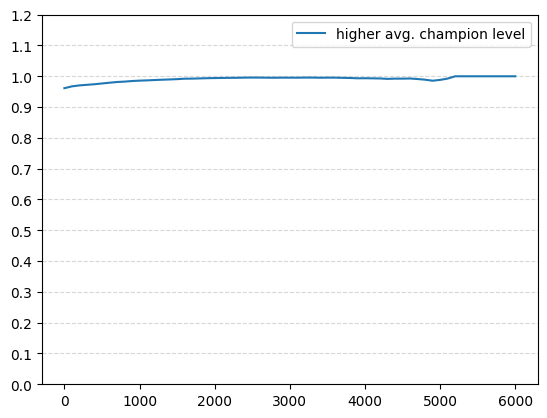

In [7]:
import matplotlib.pyplot as plt
print(get_team_champion_levels(games[1]))
diffs = [i * 100 for i in range(0, 61)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_champion_level_winrate(games, d)
    winrates_higher.append(wr)
print(winrates_higher)
plt.ylim(0, 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 13)])
plt.plot(diffs, winrates_higher, label="higher avg. champion level")
#plt.plot(diffs, winrates_lower, label="lower avg. level")
plt.legend()
plt.show()

In [8]:
print(get_percentage_of_surrendered_games(games))

0.29506564619500963
